In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import numpy as np

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
8,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
3,pretrained_1,linear_regression,Transformer,,-1,-1,20,12,8,fix_linear_regression_standard
5,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,fix_linear_regression_standard
2,pretrained_ori,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
0,toy_ori,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
1,toy_w1_0.9,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
4,toy_w1_1,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
6,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
7,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [3]:
task = "linear_regression"
#task = "sparse_linear_regression"
# task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "toy_w1_0.9"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

run_name: linear_regression_toy, id: toy_w1_0.9
------------------------
conf: Munch({'config': 'conf/toy.yaml', 'inherit': ['/home/hlv8980/in-context-learning-fork/src/conf/models/standard.yaml', '/home/hlv8980/in-context-learning-fork/src/conf/wandb.yaml'], 'model': Munch({'family': 'gpt2', 'n_dims': 5, 'n_embd': 256, 'n_head': 8, 'n_layer': 12, 'n_positions': 11}), 'out_dir': '../models/linear_regression/8188737d-e3ce-4bbb-944c-cf5b1f359f66', 'test_run': False, 'training': Munch({'batch_size': 64, 'curriculum': Munch({'dims': Munch({'end': 5, 'inc': 1, 'interval': 2000, 'start': 5}), 'points': Munch({'end': 11, 'inc': 2, 'interval': 2000, 'start': 11})}), 'data': 'gaussian', 'keep_every_steps': 100000, 'learning_rate': 0.0001, 'num_tasks': None, 'num_training_examples': None, 'resume_id': None, 'save_every_steps': 1000, 'task': 'linear_regression', 'task_kwargs': Munch({}), 'train_steps': 5001}), 'wandb': Munch({'entity': 'northwestern-in-context-learning', 'log_every_steps': 100, '

100%|██████████| 15/15 [00:00<00:00, 124830.48it/s]

------------------------
metrics: {'standard': {'gpt2_embd=256_layer=12_head=8': {'mean': [17.496662139892578, 5.8280463218688965, 4.111911773681641, 2.5060505867004395, 2.051184892654419, 1.4370704889297485, 1.1970641613006592, 0.819703221321106, 0.7261678576469421, 0.61107337474823, 0.550697922706604], 'std': [27.26847267150879, 9.524076461791992, 8.88132095336914, 5.390805721282959, 4.957609176635742, 3.645972490310669, 3.170858383178711, 2.1111581325531006, 1.7655521631240845, 1.478047490119934, 1.4005919694900513], 'bootstrap_low': [16.184574127197266, 5.379804611206055, 3.7359981536865234, 2.2711825370788574, 1.8201830387115479, 1.2746505737304688, 1.0608386993408203, 0.7277241945266724, 0.6485825777053833, 0.5412331819534302, 0.48858290910720825], 'bootstrap_high': [18.75863265991211, 6.279738903045654, 4.568453788757324, 2.7580466270446777, 2.2945713996887207, 1.6226524114608765, 1.3429267406463623, 0.9175467491149902, 0.8128207921981812, 0.6829019784927368, 0.6202026605606079]

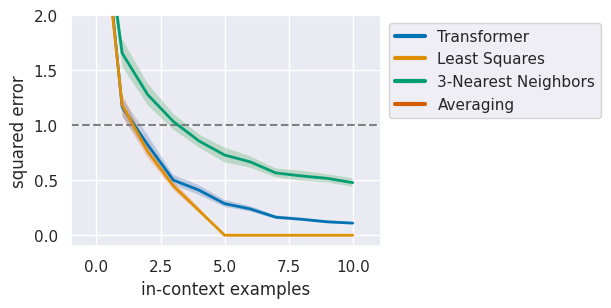

In [4]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [5]:
from samplers import get_data_sampler
from tasks import get_task_sampler
print(conf.training.curriculum.points.end)

11


In [6]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size
data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

task = task_sampler()
metric = task.get_metric()
sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

In [7]:
def R_Square_Error(ys, pred):
    # Step 2: Calculate the mean of the actual outcomes
    y_mean = torch.mean(ys)

    # Step 3: Compute SS_tot and SS_res
    SS_tot = torch.sum((ys - y_mean) ** 2)
    SS_res = torch.sum((ys - pred) ** 2)

    # Step 4: Calculate R^2
    R_square = 1 - SS_res / SS_tot
    return R_square

### 4.3 Retrieving Similar Samples

####  Part 1 - Linear regression with best prompts -- COS

In [18]:
# sampling 200
n_pairs = 150
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size # this is 64
n_batches = 20
prompt_length = 2*conf.training.curriculum.points.end-1

# compute similarity
def similarity(x, x_test, method="MSE"):
    if method == "MSE":
        squared_differences = (x - x_test) ** 2
        mse = torch.mean(squared_differences)
        return mse
    elif method == "cos":
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        x = x.unsqueeze(0)
        x_test = x_test.unsqueeze(0)
        return cos(x, x_test)
    
xs_list_best = []
ys_list_best = []
# all_errors_cos_best_prompt = []
actual_points_best_prompt = [[] for _ in range(prompt_length)]
predicted_points_best_prompt = [[] for _ in range(prompt_length)]
for batch_idx in tqdm(range(n_batches)):
    # Sample 201 points
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=n_pairs+1, w1=0.9, w2=0.1)
    xs_list_best.append(xs)
    ys= task.evaluate(xs)
    ys_list_best.append(ys)
    batch_errors = []
    for j in range(1, prompt_length+1):
        prompt_xs = np.zeros((batch_size, prompt_length, n_dims))
        prompt_ys = np.zeros((batch_size, prompt_length))
        for batch_idx in range(batch_size):
            # test sample
            x_test, y_test = xs[batch_idx, -1, :], ys[batch_idx, -1]
            sims = torch.tensor([similarity(xs[batch_idx, i, :], x_test, "cos") for i in range(n_pairs)])
            selected_indices = torch.topk(sims, j-1, largest=False).indices
            prompt_xs[batch_idx, :j-1, :] = xs[batch_idx, selected_indices, :]
            prompt_ys[batch_idx, :j-1] = ys[batch_idx, selected_indices]
            prompt_xs[batch_idx, j-1, :] = x_test
            prompt_ys[batch_idx, j-1] = y_test
            
        prompt_xs = torch.from_numpy(prompt_xs).float()
        prompt_ys = torch.from_numpy(prompt_ys).float()
        with torch.no_grad():
            pred = model(prompt_xs, prompt_ys)
            
        actual_points_best_prompt[j-1].extend(ys[:, j-1])
        predicted_points_best_prompt[j-1].extend(pred[:, j-1])




  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
R_square_values_worst = []

for point_idx in range(prompt_length):
    actual = torch.tensor(actual_points_best_prompt[point_idx])
    predicted = torch.tensor(predicted_points_best_prompt[point_idx])
    R_square = R_Square_Error(actual, predicted)
    R_square_values_worst.append(R_square)

##### Part 2 - Linear regression with Random prompts

In [20]:
all_errors_random_prompt = []
actual_points_random_prompt = [[] for _ in range(prompt_length)]
predicted_points_random_prompt = [[] for _ in range(prompt_length)]
for batch_idx in tqdm(range(1)):
    # Sample 201 points
    # xs = xs_list_best[batch_idx]
    # ys = ys_list_best[batch_idx]
    xs = xs_list_best[batch_idx]
    ys = ys_list_best[batch_idx]
    for j in range(1, prompt_length+1):
        prompt_xs = np.zeros((batch_size, prompt_length, n_dims))
        prompt_ys = np.zeros((batch_size, prompt_length))
        for batch_idx in range(batch_size):
            x_test, y_test = xs[batch_idx, -1, :], ys[batch_idx, -1]
            selected_indices = np.random.choice(n_pairs+1, j-1, replace=False)
            prompt_xs[batch_idx, :j-1, :] = xs[batch_idx, selected_indices, :]
            prompt_ys[batch_idx, :j-1] = ys[batch_idx, selected_indices]
            prompt_xs[batch_idx, j-1, :] = x_test
            prompt_ys[batch_idx, j-1] = y_test
            
        prompt_xs = torch.from_numpy(prompt_xs).float()
        prompt_ys = torch.from_numpy(prompt_ys).float()
        with torch.no_grad():
            pred = model(prompt_xs, prompt_ys)
            
        actual_points_random_prompt[j-1].extend(ys[:, j-1])
        predicted_points_random_prompt[j-1].extend(pred[:, j-1])
            
    

R_square_values_random_prompt = []

for point_idx in range(prompt_length):
    actual = torch.tensor(actual_points_random_prompt[point_idx])
    predicted = torch.tensor(predicted_points_random_prompt[point_idx])
    R_square = R_Square_Error(actual, predicted)
    R_square_values_random_prompt.append(R_square)



  0%|          | 0/1 [00:00<?, ?it/s]

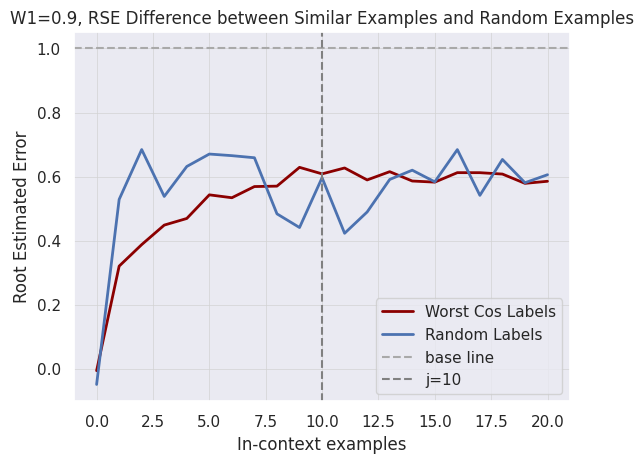

In [17]:

plt.plot(range(prompt_length), R_square_values_worst, label="Worst Cos Labels", linewidth=2, color="darkred")
plt.plot(range(prompt_length), R_square_values_random_prompt, label="Random Labels", linewidth=2)
plt.axhline(1, ls="--", color="darkgray", label="base line")
plt.axvline(x=10, color="gray", linestyle="--", label="j=10")
plt.legend()
plt.xlabel('In-context examples')
plt.ylabel('Root Estimated Error')
plt.title('W1=0.9, RSE Difference between Similar Examples and Random Examples')
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
# plt.savefig("../output/4_3.pdf", bbox_inches = "tight", transparent=True)
plt.show()

In [21]:
n_batches = 50
prompt_length = 2*conf.training.curriculum.points.end-1
# # save xs and ys for the 4.2 experiment
xs_list = [] 
ys_list = [] 
actual_points_w_1 = [[] for _ in range(prompt_length)]
predicted_points_w_1 = [[] for _ in range(prompt_length)]
# Generate data and perform the experiment
for _ in tqdm(range(n_batches)):

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length, w1=0.9, w2=0.1)
    # 64 x 101 x 20
    xs_list.append(xs)
    ys = task.evaluate(xs)
    # 64 x 101
    ys_list.append(ys)

    with torch.no_grad():
        pred = model(xs, ys)
    for j in range(prompt_length):
        actual_points_w_1[j].extend(ys[:, j])
        predicted_points_w_1[j].extend(pred[:, j])

R_square_values_w_1 = []

for point_idx in range(prompt_length):
    actual = torch.tensor(actual_points_w_1[point_idx])
    predicted = torch.tensor(predicted_points_w_1[point_idx])
    R_square = R_Square_Error(actual, predicted)
    R_square_values_w_1.append(R_square)

  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:

actual_points_random = [[] for _ in range(prompt_length)]
predicted_points_random = [[] for _ in range(prompt_length)]

# Generate data and perform the experiment
for batch_idx in tqdm(range(50)):
    xs = xs_list[batch_idx]
    ys = ys_list[batch_idx]

    # j's idx starts at 1, but in graph, we refer it to 0
    for j in range(1, prompt_length+1):
        permuted_ys = np.copy(ys)
        if j > 2:  # if j == 1, 2, there are no prior labels or no need to permuted
            for i in range(batch_size):
                np.random.shuffle(permuted_ys[i, :j-1])
    
    # Transfer np array to tensor
    permuted_ys_tensor = torch.from_numpy(permuted_ys)
    # predict with the si
    with torch.no_grad():
        pred = model(xs, permuted_ys_tensor)
    
    for j in range(prompt_length):
        actual_points_random[j].extend(ys[:, j])
        predicted_points_random[j].extend(pred[:, j])

R_square_values_w_random = []

for point_idx in range(prompt_length):
    actual = torch.tensor(actual_points_random[point_idx])
    predicted = torch.tensor(predicted_points_random[point_idx])
    R_square = R_Square_Error(actual, predicted)
    R_square_values_w_random.append(R_square)

  0%|          | 0/50 [00:00<?, ?it/s]

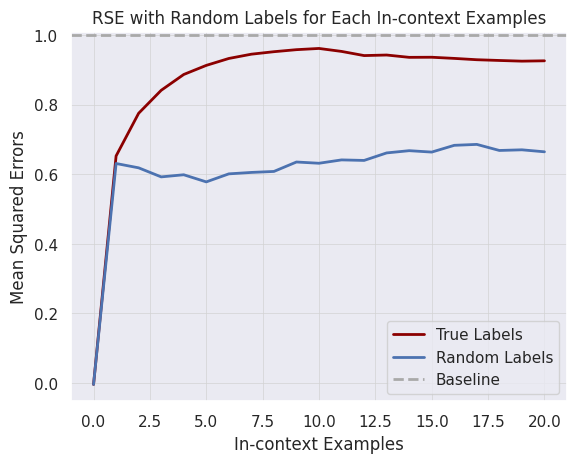

In [15]:

plt.plot(range(prompt_length), R_square_values_w_1, label="True Labels",color='darkred', linewidth=2)
plt.plot(range(prompt_length), R_square_values_w_random, label="Random Labels", linewidth=2)
plt.axhline(1, ls="--", color="darkgray", label="Baseline", linewidth=2)
# existing_ticks = plt.xticks()[0]
# new_ticks = sorted(set(existing_ticks).union({10}))
# plt.xticks(new_ticks)
plt.legend()
plt.xlabel('In-context Examples')
plt.ylabel('Mean Squared Errors')
plt.title('RSE with Random Labels for Each In-context Examples')
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
# plt.savefig("../output/4.2_Std_Sensitivity_to_Label_Format.pdf", bbox_inches = "tight", transparent=True)
plt.show()